In [51]:
import os # for detecting CPU cores
import configparser # to load standard config and parameters
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from icecream import ic

warnings.filterwarnings('ignore')
%load_ext watermark
%matplotlib inline


The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [52]:
# Load external config file
config = configparser.ConfigParser()
config.read("../src/config.ini")

PATH_DATA_RAW = config["PATHS"]["PATH_DATA_RAW"]
PATH_DATA_INT = config["PATHS"]["PATH_DATA_INT"]
PATH_DATA_PRO = config["PATHS"]["PATH_DATA_PRO"]
PATH_REPORTS = config["PATHS"]["PATH_REPORTS"]
PATH_MODELS = config["PATHS"]["PATH_MODELS"]
PATH_SUB = config["PATHS"]["PATH_SUB"]

# Telegram Bot
token = config["TELEGRAM"]["token"]
chat_id = config["TELEGRAM"]["chat_id"]
FILENAME_NB = "05_deep_learning_model_feature_engineering" # for Telegram messages

# Set global randome state
rnd_state = 42

# Define available cpu cores
n_cpu = os.cpu_count()
print("Number of CPUs used:", n_cpu)

Number of CPUs used: 8


In [53]:
import urllib, requests #for Telegram notifications

def send_telegram_message(message):
    """Sending messages to Telegram bot via requests.get()."""
    
    message = f"{FILENAME_NB}:\n{message}"

    # Using "try and except" to ensure that the notebook execution will not be stopped only because of problems with the bot.
    # Example: No network connection.
    # ISSUE: Be careful, an error messages will leak your Telegram Bot Token when uploaded to GitHub.
    try:
        url = 'https://api.telegram.org/bot%s/sendMessage?chat_id=%s&text=%s'%(token, chat_id, urllib.parse.quote_plus(message))
        _ = requests.get(url, timeout=10)
    
    except Exception as e:
        print('\n\nSending message to Telegram Bot was not successful.\n\n')
        print(e)
        
    return None

In [54]:
train_df = pd.read_pickle(PATH_DATA_INT+'train-opt.pkl')
test_df = pd.read_pickle(PATH_DATA_INT+'test-opt.pkl')
sample_df = pd.read_csv(PATH_DATA_RAW+'sample_submission.csv')

In [55]:
features_num = train_df.drop(['id','target'], axis=1).columns
feature_cols = features_num.to_list()
X = train_df.drop(['id','target'], axis=1).copy()
y = train_df['target'].copy()
X_test = test_df.drop(['id'], axis=1).copy()


# Feature Engineering

## KMeans Clustering

In [56]:
from sklearn.cluster import KMeans

n_clusters_1 = 9
cluster_cols = [f"cluster{i+1}" for i in range(n_clusters_1)]
#kmeans = KMeans(n_clusters=n_clusters_1, n_init=50, max_iter=500, random_state=rnd_state)
kmeans = KMeans(n_clusters=n_clusters_1, init="k-means++", max_iter=500, random_state=rnd_state)

ic(n_clusters_1);
#ic(cluster_cols);

ic| n_clusters_1: 9


In [57]:
# cluster distance instead of cluster number

# train
X_cd = kmeans.fit_transform(X[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=train_df.index)
X = X.join(X_cd)

# test
X_cd = kmeans.transform(X_test[feature_cols])
X_cd = pd.DataFrame(X_cd, columns=cluster_cols, index=test_df.index)
X_test = X_test.join(X_cd)

In [58]:
feature_cols += cluster_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 109


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f99,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,cluster7,cluster8,cluster9
0,0.106643,3.59437,132.804001,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,0.240496,368.103516,4331.542969,1872.714233,130.496384,1266.384033,754.422852,3045.085449,45.292267,702.417664
1,0.125021,1.67336,76.533600,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,0.024719,423.519989,4387.707031,1928.705566,73.168404,1322.239380,745.363220,3101.187500,93.357513,758.153076
2,0.036330,1.49747,233.546005,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,0.148209,266.734222,4230.669434,1771.629883,228.791931,1165.150269,735.437988,2944.131836,67.663956,601.147217
3,-0.014077,0.24600,779.966980,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,0.044873,289.152924,3684.921143,1227.327515,777.669495,623.008423,968.308899,2398.770020,615.650696,90.275833
4,-0.003259,3.71542,156.128006,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,0.072798,344.559052,4308.183105,1849.302124,152.715668,1242.934937,749.709351,3021.706299,27.395741,678.936646


## Polynomial Features


In [59]:
from sklearn.preprocessing import PolynomialFeatures


In [60]:
poly = PolynomialFeatures(degree=2, interaction_only=True)

X_poly = poly.fit_transform(X[cluster_cols])
T_poly = poly.transform(X_test[cluster_cols])

poly_cols = [f"cluster_poly{i+1}" for i in range(X_poly.shape[1])]

X_poly_df = pd.DataFrame(X_poly, columns=poly_cols, index=X.index)
T_poly_df = pd.DataFrame(T_poly, columns=poly_cols, index=X_test.index)

X = pd.concat([X, X_poly_df], axis=1)
X_test = pd.concat([X_test, T_poly_df], axis=1)


In [61]:
feature_cols += poly_cols
ic(len(feature_cols));
X.head()

ic| len(feature_cols): 155


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,cluster_poly37,cluster_poly38,cluster_poly39,cluster_poly40,cluster_poly41,cluster_poly42,cluster_poly43,cluster_poly44,cluster_poly45,cluster_poly46
0,0.106643,3.59437,132.804001,3.18428,0.081971,1.18859,3.73238,2.266270,2.09959,0.012330,...,955389.0625,3856247.500,57357.402344,8.895305e+05,2297282.00,34169.519531,529919.937500,1.379188e+05,2.138922e+06,31814.087891
1,0.125021,1.67336,76.533600,3.37825,0.099400,5.09366,1.27562,-0.471318,4.54594,0.037706,...,985548.6250,4100512.250,123440.984375,1.002460e+06,2311511.00,69585.257812,565099.437500,2.895192e+05,2.351175e+06,70779.289062
2,0.036330,1.49747,233.546005,2.19435,0.026914,3.12694,5.05687,3.849460,1.80187,0.056995,...,856895.7500,3430356.000,78838.679688,7.004268e+05,2165226.50,49762.644531,442106.500000,1.992116e+05,1.769857e+06,40676.000000
3,-0.014077,0.24600,779.966980,1.89064,0.006948,1.53112,2.69800,4.517330,4.50332,0.123494,...,603264.6250,1494453.875,383555.562500,5.624261e+04,2322750.25,596140.062500,87414.890625,1.476804e+06,2.165510e+05,55578.378906
4,-0.003259,3.71542,156.128006,2.14772,0.018284,2.09859,4.15492,-0.038236,3.37145,0.034166,...,931839.9375,3755784.250,34051.121094,8.438741e+05,2265401.50,20538.843750,509005.156250,8.278188e+04,2.051547e+06,18599.972656


In [62]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

transformer_num = make_pipeline(StandardScaler(),)

preprocessor = make_column_transformer((transformer_num, feature_cols))

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify=y, train_size=0.75, random_state=rnd_state
)

# X_train = preprocessor.fit_transform(X_train)
# X_valid = preprocessor.transform(X_valid)
# X_test = preprocessor.transform(X_test)

input_shape = [X_train.shape[1]]
print(input_shape)


[155]


In [63]:
import gc
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

In [64]:
gc.collect()

# Set seed
tf.random.set_seed(rnd_state)

model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=input_shape),
        layers.Dense(4, activation="relu"),
        layers.Dense(4, activation="relu"),
        layers.Dense(1, activation="sigmoid"),  # sigmoid for binary output
    ]
)

model.summary()

model.compile(
    optimizer="adam",  # SGD is more sensitive to differences of scale
    loss="binary_crossentropy",
    metrics=["AUC"],
)

early_stopping = EarlyStopping(patience=10, min_delta=0.0001, restore_best_weights=True)

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0,  # hide the output because we have so many epochs
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_1 (Batc  (None, 155)              620       
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 4)                 624       
                                                                 
 dense_5 (Dense)             (None, 4)                 20        
                                                                 
 dense_6 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,269
Trainable params: 959
Non-trainable params: 310
_________________________________________________________________


Best Validation Loss: 0.567732
Best Validation AUC: 0.755854


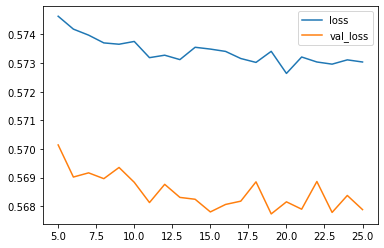

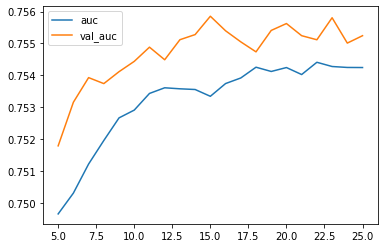

In [65]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["auc", "val_auc"]].plot()

print(
    ("Best Validation Loss: {:0.6f}" + "\nBest Validation AUC: {:0.6f}").format(
        history_df["val_loss"].min(), history_df["val_auc"].max()
    )
)


# SGD:
# Best Validation Loss: 0.565582
# Best Validation Accuracy: 0.750882

# ADAM:
# 06 Clusters PF-Degree 2: 0.755635
# 08 Clusters PF-Degree 2: 0.755701
# 08 Clusters PF-Degree 3: 0.754991
# 09 Clusters PF-Degree 2: 0.755704 
# 09 Clusters PF-Degree 2: 0.755857 ** (learning rate = 0.0001)
# 10 Clusters PF-Degree 2: 0.755059

In [66]:
best_score = 0
best_score = history_df["val_auc"].max()
ic(best_score)

message = f'New baseline score: {best_score}'
send_telegram_message(message)

ic| best_score: 0.7558540105819702


In [67]:
preds_test = model.predict(X_test)

# Submitting Results

In [68]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
now = now.strftime("%Y-%m-%d")

#mlflow_run_id = str(run.info.run_id)
objective = "DL-FE_nopt"

curr_submission_fn = f"{now}_submission_{objective}.csv"

sample_df['target'] = preds_test
sample_df.to_csv(PATH_SUB + curr_submission_fn, index=False)

print(curr_submission_fn)

2021-11-12_submission_DL-FE_nopt.csv


In [69]:
sample_df.tail()

,id,target
539995,1139995,0.753282
539996,1139996,0.731915
539997,1139997,0.637944
539998,1139998,0.725104
539999,1139999,0.712008


In [70]:
# !kaggle competitions submit tabular-playground-series-nov-2021 -f {PATH_SUB+curr_submission_fn} -m {curr_submission_fn}

# Tuning Hyperparameters w/ Optuna

In [75]:
# 0.7565599679946899 | Kaggle: 0.74796
ic(best_score);

ic| best_score: 0.7558540105819702


In [76]:
import warnings
from icecream import ic
import optuna

from keras.backend import clear_session
from keras.layers import Dense
from keras.models import Sequential

In [77]:
def objective(trial):
    global best_score
    global X_train, X_valid, y_train, y_valid

    # Clear clutter from previous Keras session graphs.
    clear_session()
    gc.collect()

    # Set seed
    tf.random.set_seed(rnd_state)

    input_shape = [X_train.shape[1]]

    model = Sequential()

    batch_size = trial.suggest_int("batch_size", 10, 800)
    # epochs = trial.suggest_int("epochs", 100, 1000, 100)
    epochs = 2000  # we are using early stops to control the epochs
    n_layers = trial.suggest_int("n_layers", 3, 3, 1) # keep three layers only
    #ic(n_layers)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    patience = trial.suggest_int("patience", 10, 200)
    # optimizer=trial.suggest_categorical("activation", ["sgd", "adam"]) # TODO: needs to be updated, not working yet

    # model.add(keras.layers.Flatten())
    # model.add(layers.Dense(input_shape=input_shape, activation="relu"))

    model.add(layers.BatchNormalization(input_shape=input_shape))

    for i in range(n_layers):
        #ic(i)
        num_hidden = trial.suggest_int(f"n_units_l{i}", 2, input_shape[0], log=True)
        model.add(layers.Dense(num_hidden, activation="swish"))
        # ic(num_hidden)

    # last layer
    model.add(Dense(1, activation="sigmoid"))

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=["AUC"],
    )

    early_stopping = EarlyStopping(
        monitor='val_auc', patience=patience, min_delta=learning_rate, restore_best_weights=True,
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_valid, y_valid),  # TODO: Test Keras validation function
        shuffle=True,
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[early_stopping],
        verbose=0,  # hide the output because we have so many epochs
    )

    # Evaluate the model accuracy on the validation set.
    score = model.evaluate(X_valid, y_valid, verbose=0)

    if score[1] > best_score:
        best_score = score[1]
        ic(best_score)
        message = f'New best score: {best_score}'
        send_telegram_message(message)

    return score[1]


In [78]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100) # TODO: load, split and send data from function


[I 2021-11-12 12:00:04,906] A new study created in memory with name: no-name-c3487abb-f8fb-4e89-b7ec-4ccfa0bebf3d
[I 2021-11-12 12:34:30,668] Trial 0 finished with value: 0.7443585395812988 and parameters: {'batch_size': 247, 'n_layers': 3, 'learning_rate': 0.04052613379874322, 'patience': 165, 'n_units_l0': 2, 'n_units_l1': 2, 'n_units_l2': 4}. Best is trial 0 with value: 0.7443585395812988.
[I 2021-11-12 12:41:46,974] Trial 1 finished with value: 0.7514100074768066 and parameters: {'batch_size': 319, 'n_layers': 3, 'learning_rate': 0.006574350531834457, 'patience': 43, 'n_units_l0': 12, 'n_units_l1': 22, 'n_units_l2': 25}. Best is trial 1 with value: 0.7514100074768066.
[I 2021-11-12 13:00:43,458] Trial 2 finished with value: 0.7508881092071533 and parameters: {'batch_size': 377, 'n_layers': 3, 'learning_rate': 0.009826377377703387, 'patience': 138, 'n_units_l0': 6, 'n_units_l1': 2, 'n_units_l2': 68}. Best is trial 1 with value: 0.7514100074768066.


KeyboardInterrupt: 

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


In [ ]:
# save results
df_results = study.trials_dataframe()
df_results.to_pickle('df_optuna_results.pkl')
df_results.to_csv('df_optuna_results.csv')

https://machinelearningapplied.com/hyperparameter-search-with-optuna-part-3-keras-cnn-classification-and-ensembling/